# Inference with FCNv2

## Setup

In [1]:
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import json

from scipy.signal import periodogram

# Set number of GPUs to use to 1
os.environ["WORLD_SIZE"] = "1"
# Set model registry as a local folder
model_registry = os.path.join(os.path.dirname(os.path.realpath(os.getcwd())), "models")
os.makedirs(model_registry, exist_ok=True)
os.environ["MODEL_REGISTRY"] = model_registry
print(f"{os.environ['MODEL_REGISTRY']}")
# With the enviroment variables set now we import Earth-2 MIP
from earth2mip import registry, inference_ensemble
from earth2mip.initial_conditions import cds
from earth2mip.networks.fcnv2_sm import load as fcnv2_sm_load

/home/workspace/FCN/earth2mip/models


# Run Full Inference

In [2]:
import logging
import os

# Ensure the logs directory exists
os.makedirs("logs", exist_ok=True)

# Configure logging
logging.basicConfig(
    filename=os.path.join("logs", "update_netcdf.log"),
    filemode='w',
    format='%(asctime)s - %(levelname)s - %(message)s',
    level=logging.DEBUG
)

# Create a logger object
logger = logging.getLogger()


In [3]:
from earth2mip.schema import EnsembleRun
from earth2mip.inference_ensemble import run_inference
import torch
import numpy as np
import earth2mip.initial_conditions
from earth2mip.schema import Grid, PerturbationStrategy

# Load model(s) from registry
package = registry.get_model("fcnv2_sm")
print("loading FCNv2 small model, this can take a bit")
model = fcnv2_sm_load(package)
perturb = None  # Use default perturbation if not specified
group = None  # Use default torch distributed group if not specified
progress = True  # Show progress bar


loading FCNv2 small model, this can take a bit


In [ ]:
model.in_channel_names

In [4]:
from earth2mip.weather_events import WeatherEvent, WeatherEventProperties, Domain, Window, Diagnostic

"""# Define diagnostics
diagnostic = Diagnostic(type="raw", channels=["u100", "u200"], nbins=10)
data_source = cds.DataSource(model.in_channel_names)

# Define domains
window = Window(
    name="global",
    lat_min=-90,
    lat_max=90,
    lon_min=0,
    lon_max=360,
    diagnostics=[diagnostic]
)

# Define weather event properties
weather_event_properties = WeatherEventProperties(
    name="example_event7",
    start_time=datetime.datetime(2023, 5, 21),
    initial_condition_source='era5',
)

# Create WeatherEvent
weather_event = WeatherEvent(
    properties=weather_event_properties,
    domains=[window]
)"""

# EnsembleRun contains settings for the ensemble forecast
config = {
    "ensemble_members": 4,
    "noise_amplitude": 0.05,
    "simulation_length": 10,
    "weather_event": {
        "properties": {
            "name": "Globe",
            "start_time": "2018-06-01 00:00:00",
            "initial_condition_source": "cds",
        },
        "domains": [
            {
                "name": "global",
                "type": "Window",
                "diagnostics": [{"type": "raw", "channels": ["t2m", "u10m"]}],
            }
        ],
    },
    "output_path": "outputs/01_ensemble_notebook",
    "output_frequency": 1,
    "weather_model": "fcnv2_sm",
    "seed": 12345,
    "use_cuda_graphs": False,
    "ensemble_batch_size": 1,
    "autocast_fp16": False,
    "perturbation_strategy": "correlated",
    "noise_reddening": 2.0,
}

In [5]:
config_str = json.dumps(config)
inference_ensemble.main(config_str)

# Step 3: Call the run_inference function with the modified config
run_inference(
    model=model,
    config=config,
    perturb=perturb,
    group=group,
    progress=progress,
    data_source=data_source
)

# Process Output Data

In [6]:
import xarray
def open_ensemble(f, domain, chunks={"time": 1}):
    time = xarray.open_dataset(f).time
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=time)


output_path = config["output_path"]
domains = config["weather_event"]["domains"][0]["name"]
ensemble_members = config["ensemble_members"]
ds = open_ensemble(os.path.join(output_path, "ensemble_out_0.nc"), domains)
ds

<xarray.Dataset> Size: 731MB
Dimensions:  (lat: 721, lon: 1440, ensemble: 4, time: 11)
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 88B 2018-06-01 ... 2018-06-03T12:00:00
Dimensions without coordinates: ensemble
Data variables:
    imin     int64 8B ...
    imax     int64 8B ...
    jmin     int64 8B ...
    jmax     int64 8B ...
    t2m      (ensemble, time, lat, lon) float64 365MB dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
    u10m     (ensemble, time, lat, lon) float64 365MB dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
Attributes:
    model:          fcnv2_sm
    config:         {"weather_model": "fcnv2_sm", "simulation_length": 10, "p...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2018-06-0...
    date_created:   2024-05-27T19:05:25.525498
    history:        /root/miniconda3/envs/py3.11/lib/python3.11/site-packages...
    institution:    NVIDIA
    Conventions:    CF-1.10

# Post Processing

In [7]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import TwoSlopeNorm

countries = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    facecolor="none",
    edgecolor="black",
)

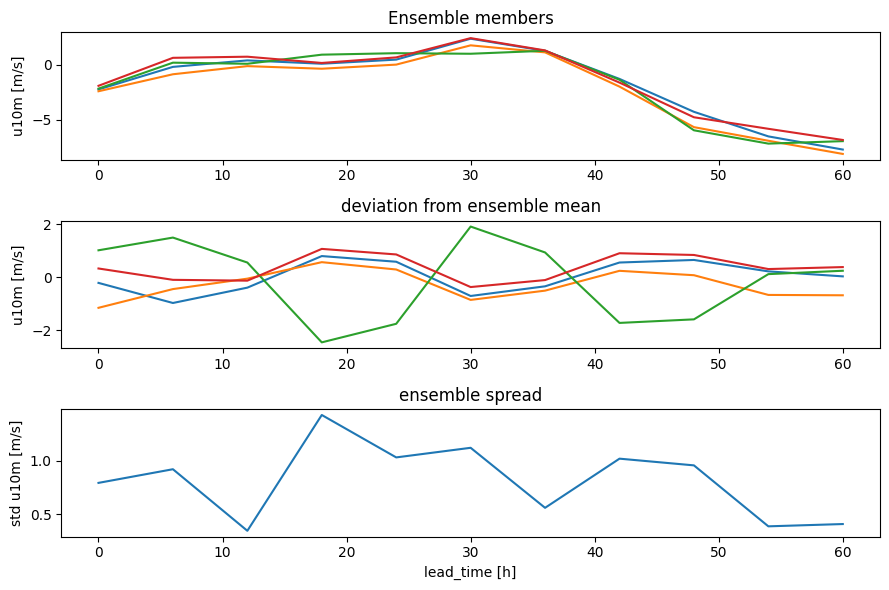

In [8]:
plt.close("all")
lead_time = np.array(
    (pd.to_datetime(ds.time) - pd.to_datetime(ds.time)[0]).total_seconds() / 3600
)
nyc_lat = 40
nyc_lon = 360 - 74
NYC = ds.sel(lon=nyc_lon, lat=nyc_lat)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(311)
ax.set_title("Ensemble members")
ax.plot(lead_time, NYC.u10m.T)
ax.set_ylabel("u10m [m/s]")

ax = fig.add_subplot(312)
ax.set_title("deviation from ensemble mean")
ax.plot(lead_time, NYC.t2m.T - NYC.t2m.mean("ensemble"))
ax.set_ylabel("u10m [m/s]")

ax = fig.add_subplot(313)
ax.set_title("ensemble spread")
ax.plot(lead_time, NYC.t2m.std("ensemble"))
ax.set_xlabel("lead_time [h]")
ax.set_ylabel("std u10m [m/s]")
plt.tight_layout()
plt.savefig(f"{output_path}/new_york_zonal_winds.png")

In [ ]:
plt.close("all")
fig = plt.figure(figsize=(15, 10))
plt.rcParams["figure.dpi"] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)

data = ds.t2m[0, -1, :, :]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(131, projection=proj)
ax.set_title("First ensemble member t2m (K)")
img = ax.pcolormesh(
    ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic"
)
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor="black", linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle="--")

data = ds.t2m[-1, -1, :, :]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(132, projection=proj)
plt.rcParams["figure.dpi"] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)
ax.set_title("Last ensemble member t2m (K)")
img = ax.pcolormesh(
    ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic"
)
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor="black", linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle="--")

ds_ensemble_std = ds.std(dim="ensemble")
data = ds_ensemble_std.t2m[-1, :, :]
# norm = TwoSlopeNorm(vmin=data.min().values, vcenter=5, vmax=data.max().values)
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)
ax = fig.add_subplot(133, projection=proj)
ax.set_title("ensemble std  t2m (K)")
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), cmap="seismic")
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor="black", linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle="--")
plt.savefig(f"{output_path}/gloabl_surface_temp_contour.png")